# Solution: Simulating competing hazards

The model we want to specify in this etivity has 3 compartments: I (infected), R (recovered) and M (dead). Like in etivity 1, infected people can recover at a rate $\gamma$. Additionally they can also now die (transition to the M compartment) at a rate $\mu$.

The differential equations for this model look like this:
\begin{align}
\frac{dI}{dt} & = -\gamma I -\mu I \\
\frac{dR}{dt} & = \gamma I \\
\frac{dM}{dt} & = \mu I
\end{align}

This corresponds to the following model diagram:

<img src="../GraphicsAndData/w1_nb2_model_diagram.png">

As you can see, the equation describing the rate of change in the recovered (R) compartment (second line) is not affected by this addition. However, we need a new equation describing the rate of change in the deceased (M) compartment (third line). People move into this compartment from the infected compartment (I) at a rate $\mu$ - this transition also needs to be added in the rate of change in the infected compartment I (first line). 

The **model function** describing this set of differential equations looks like this:

In [1]:
# As always, the model function takes as input arguments (in the following order): time, state and parameters
cohort_model <- function(time, state, parameters) {  

    with(as.list(c(state, parameters)), {  # tell R to unpack the variable names (I, R and M) and model parameters 
                                           # (gamma and mu) from the inputs "state" and "parameters"
        
    # The differential equations
      dI <- -gamma * I - mu * I  # included -mu * I
      dR <- gamma * I            # no change
      dM <- mu * I               # a new line to describe the rate of change in the M compartment
      
    # Return the number of people in each compartment at each timestep (in the same order as the input state variables)
    return(list(c(dI, dR, dM))) 
    })
  
}

**Defining model input and timesteps**

In [2]:
initial_state_values <- c(I = 1000000,   # at the start, there are 10^6 infected people
                          R = 0,         # no one has recovered
                          M = 0)         # no one has died 

parameters <- c(gamma = 0.1,             # the recovery rate gamma is 0.1 days^-1
                mu = 0.2)                # the mortality rate mu is 0.2 days^-1

times <- seq(from = 0, to = 4*7, by = 1) # we want to model the course of the infection over 4 weeks = 4*7 days
                                         # (remembering that the rates are in units of days^-1)

### After 4 weeks, do you expect more people to have recovered or more people to have died, and why? 

We expect more people to die than to recover because the mortality rate (0.2) is higher than the recovery rate (0.1), so people move more quickly from I to M than from I to R.

Load the deSolve package and use it to solve the differential equations:

In [3]:
library(deSolve)
library(reshape2)
library(ggplot2)

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = cohort_model,
                            parms = parameters))

Warning message:
"package 'deSolve' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Plotting the output over time indeed shows that more people have indeed died than recovered:

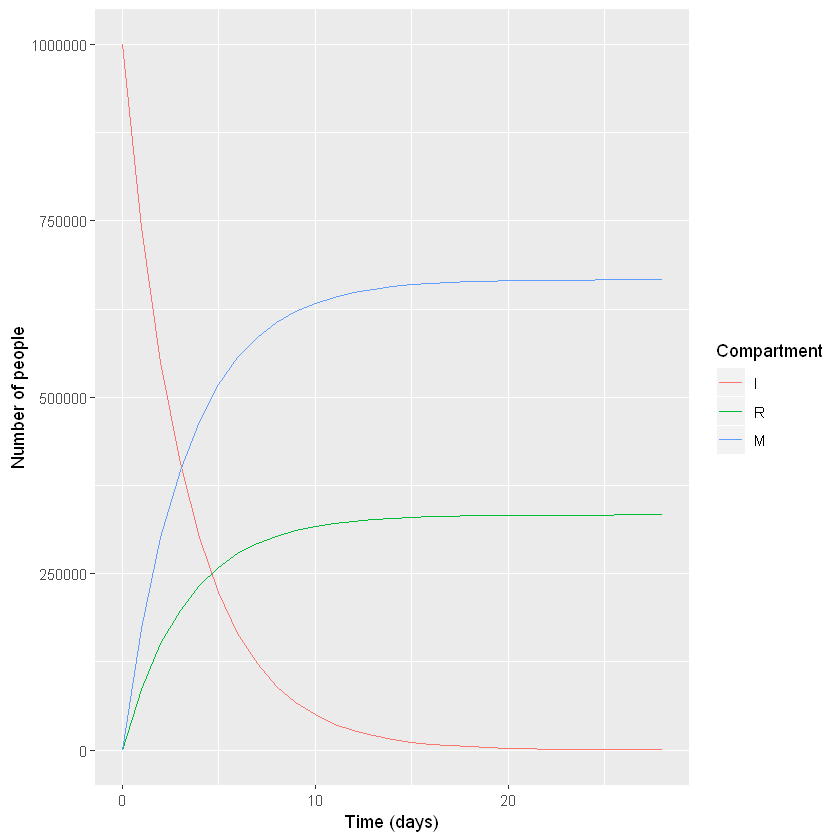

In [4]:
output_long <- melt(as.data.frame(output), id = "time")                  # turn output dataset into long format

ggplot(data = output_long,                                               # specify object containing data to plot
       aes(x = time, y = value, colour = variable, group = variable)) +  # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (days)")+                                                   # add label for x axis
  ylab("Number of people") +                                             # add label for y axis
  labs(colour = "Compartment")                                           # add legend title

# ggplot automatically adds the new compartment as a separate colour/group 
# because it is contained within the output dataframe

### Based on the model output, what proportion of the initially infected cohort died before recovering over the 4 week period?

In [5]:
# Printing the full model output:
output

time,I,R,M
0,1000000.0000,0.00,0.0
1,740818.2240,86393.93,172787.9
2,548811.6238,150396.13,300792.3
3,406569.6441,197810.12,395620.2
4,301194.1295,232935.29,465870.6
5,223130.0332,258956.66,517913.3
6,165298.7445,278233.75,556467.5
7,122456.2989,292514.57,585029.1
8,90717.8284,303094.06,606188.1
9,67205.4086,310931.53,621863.1


In [6]:
# Printing the output at timestep/day 28:
output[output$time == 28,]

# Divide the number of people who died over the 4 week period by the number of people initially infected:
output[29,"M"]/1000000
# Answer: proportion = 0.6665

,time,I,R,M
29,28,224.8659,333258.4,666516.8


[1] 0.6665168

### Now use the competing hazards formula given in the video lecture to calculate the case fatality rate. Does this agree with your answer to the previous question?

The formula is: 
\begin{align}
CFR = \frac{\mu}{\mu+\gamma} 
\end{align}

In [7]:
# Calculate this by referring to the values in the parameters vector:
parameters["mu"]/(parameters["mu"]+parameters["gamma"])
# Answer: CFR = 0.6667
# This is approximately the same as the case fatality rate observed in the model output. The agreement would be exact if we allowed the simulation to run for longer.

mu 
0.6666667

### Which value of $\mu$ do you need to get a case fatality rate of 50% assuming $\gamma$ stays fixed? 

Rearranging the CFR equation above to solve for $\mu$ gives:

\begin{align}
CFR = \frac{\mu}{\mu+\gamma} \\
\mu = CFR(\mu+\gamma) \\
\mu = \mu CFR + \gamma CFR \\
\mu - \mu CFR = \gamma CFR \\
\mu(1-CFR) = \gamma CFR \\
\mu = \frac{\gamma CFR}{1-CFR}
\end{align}

Calculating *mu* with CFR = 0.50 and *gamma* = 0.1:

\begin{align}
\mu = \frac{0.1 * 0.50}{1-0.50} \\
\mu = 0.1
\end{align}

This makes sense! If $\mu$ and $\gamma$ are equal, then they represent two competing hazards that are also equal. Thus, half of people die and half recover, so the case fatality rate is 50%.

Double-check this by modifying the code to simulate the model using these parameters:

In [8]:
# The only thing we are changing is mu, so we only need to update the parameters vector and solve the model with this
parameters <- c(gamma = 0.1, mu = 0.1)

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = cohort_model,
                            parms = parameters))

# Calculate the case fatality rate:
output[29,"M"]/1000000

# This indeed gives us approximately 0.50

[1] 0.4981511

Again we can plot the output and compare it with what we got with our previous parameters:

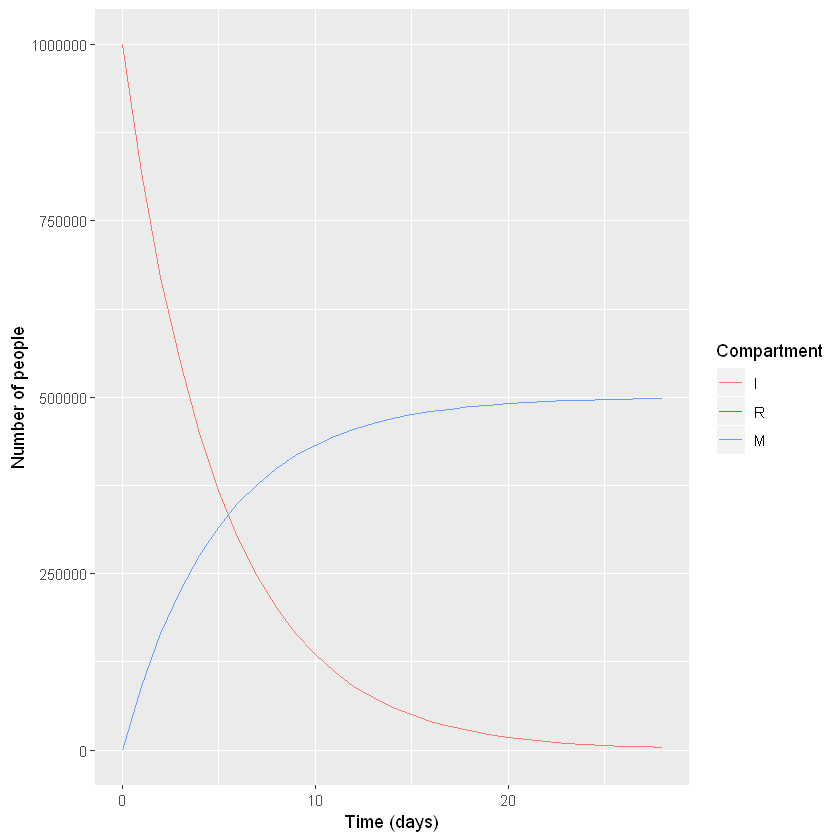

In [9]:
output_long <- melt(as.data.frame(output), id = "time")                  # turn output dataset into long format

ggplot(data = output_long,                                               # specify object containing data to plot
       aes(x = time, y = value, colour = variable, group = variable)) +  # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (days)")+                                                   # add label for x axis
  ylab("Number of people") +                                             # add label for y axis
  labs(colour = "Compartment")                                           # add legend title                         

As you notice, we only see red and blue lines here representing the number of people in the I and M compartment, despite having plotted all 3 compartments. This is just because, with $\mu$ = $\gamma$ and R(0) = M(0) (the initial number recovered and deceased), the number of recovered and deceased people is identical at each timestep so the lines completely overlap.